Cryptocurrency has gain its popularity in the last few years. As a data analyst, I have always been interested in ways to predict the prices. The following picture is a snapshot of the top 7 cryptocurrcenies according to market cap (source: https://www.coingecko.com/). The website has provided great api to retrieve pricing history so I decided to use it to pull all the pricing data.
Another 

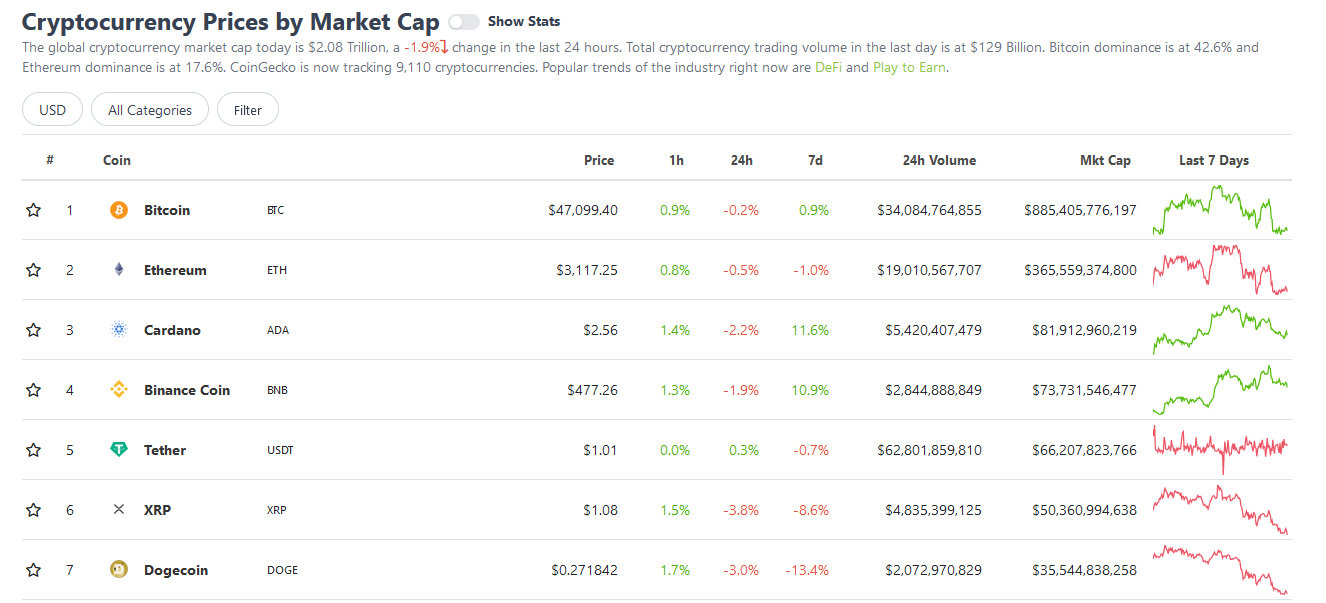

In [6]:
# Import all the necessary package for the project

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import Lasso, LinearRegression, ElasticNet, Ridge

%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [7]:
# pull the las 100 days pricing data of the top 7 cryptocurrencies using coingecko's api

cryptos = ['bitcoin', 'ethereum', 'cardano', 'binancecoin', 'tether', 'ripple', 'dogecoin']   #ripple is XRP 
crypto_df = []
for crypto in cryptos:
    url = 'https://api.coingecko.com/api/v3/coins/' + crypto + '/market_chart?vs_currency=usd&days=100'
    result = requests.get(url).json()
    prices = result['prices']
    prices_df = pd.DataFrame(prices, columns=['TimeStamp', '{} price'.format(crypto)])
    prices_df['TimeStamp'] = pd.to_datetime(prices_df['TimeStamp'], unit='ms').dt.round('1min')
    #round up to 1 minute
    crypto_df.append(prices_df)
    
#join all the info into a df    
#keep bitcoin on left because that's the target we want to predict
crypto_price_df = pd.merge(crypto_df[0], crypto_df[1], how='left', on='TimeStamp')
crypto_price_df = pd.merge(crypto_price_df, crypto_df[2], how='left', on='TimeStamp')
crypto_price_df = pd.merge(crypto_price_df, crypto_df[3], how='left', on='TimeStamp')
crypto_price_df = pd.merge(crypto_price_df, crypto_df[4], how='left', on='TimeStamp')
crypto_price_df = pd.merge(crypto_price_df, crypto_df[5], how='left', on='TimeStamp')
crypto_price_df = pd.merge(crypto_price_df, crypto_df[6], how='left', on='TimeStamp')

crypto_price_df.head(5)

,TimeStamp,bitcoin price,ethereum price,cardano price,binancecoin price,tether price,ripple price,dogecoin price
0,2021-05-21,40437.730096,2778.279661,1.793658,390.405549,1.004577,1.175644,0.397800
1,2021-05-22,37339.634201,2419.103217,1.547124,322.286746,0.998897,1.000451,0.352331
2,2021-05-23,37520.317675,2306.371267,1.468935,301.270199,1.002870,0.907339,0.343087
3,2021-05-24,34977.527802,2120.037375,1.328818,261.262253,1.001365,0.800098,0.309233
4,2021-05-25,38642.442297,2640.159632,1.543146,343.515324,1.003081,0.985859,0.363069


In [8]:
#Next I used coingecko's api to collect community's info regarding crypto

#Turned the datetime format into api's format
api_url = 'https://api.coingecko.com/api/v3/coins/bitcoin/history?date='
time_value = crypto_price_df['TimeStamp'].values
dates = pd.date_range(time_value[0], time_value[-1]).round("1d")
date_list = dates.strftime('%d-%m-%Y').tolist()

In [9]:
#Let's take a look at an exmaple in one of the date

requests.get(api_url + date_list[0]).json()['community_data']

{'facebook_likes': None,
 'twitter_followers': 90993,
 'reddit_average_posts_48h': 7.182,
 'reddit_average_comments_48h': 2737.364,
 'reddit_subscribers': 2941537,
 'reddit_accounts_active_48h': '13398.75'}

In [10]:
#Except for facebook_likes, I could use the other 5 fields as the features

#Download all the community info through api
feature1_data, feature2_data, feature3_data, feature4_data, feature5_data =[],[],[],[],[]
for date in date_list:
    #api would stop working sometimes, so add a loop to reqeust info several times
    for i in range(100):
        try:
            community_data = requests.get(api_url + date).json()['community_data']
            break
        except:
            time.sleep(5) 
    feature1 = community_data['twitter_followers']
    feature2 = community_data['reddit_average_posts_48h']
    feature3 = community_data['reddit_average_comments_48h']
    feature4 = community_data['reddit_subscribers']
    feature5 = community_data['reddit_accounts_active_48h']
    feature1_data.append([pd.to_datetime(date,format = '%d-%m-%Y'), feature1])
    feature2_data.append([pd.to_datetime(date,format = '%d-%m-%Y'), feature2])
    feature3_data.append([pd.to_datetime(date,format = '%d-%m-%Y'), feature3])
    feature4_data.append([pd.to_datetime(date,format = '%d-%m-%Y'), feature4])
    feature5_data.append([pd.to_datetime(date,format = '%d-%m-%Y'), feature5])

In [22]:
#putting all community info from those dates into dataframe
featuer1_df = pd.DataFrame(feature1_data, columns=['TimeStamp','twitter_followers'])
featuer2_df = pd.DataFrame(feature2_data, columns=['TimeStamp','reddit_average_posts_48h'])
featuer3_df = pd.DataFrame(feature3_data, columns=['TimeStamp','reddit_average_comments_48h'])
featuer4_df = pd.DataFrame(feature4_data, columns=['TimeStamp','reddit_subscribers'])
featuer5_df = pd.DataFrame(feature5_data, columns=['TimeStamp','reddit_accounts_active_48h'])

#merge all the dataframe into one
feature_df = pd.merge(featuer1_df,featuer2_df, how='left', on='TimeStamp')
feature_df = pd.merge(feature_df, featuer3_df, how='left', on='TimeStamp')
feature_df = pd.merge(feature_df, featuer4_df, how='left', on='TimeStamp')
feature_df = pd.merge(feature_df, featuer5_df, how='left', on='TimeStamp')

#merge the price and feature into one
all_df = pd.merge(crypto_price_df, feature_df, how='left', on='TimeStamp')

all_df.tail()

,TimeStamp,bitcoin price,ethereum price,cardano price,binancecoin price,tether price,ripple price,dogecoin price,twitter_followers,reddit_average_posts_48h,reddit_average_comments_48h,reddit_subscribers,reddit_accounts_active_48h
96,2021-08-25 00:00:00,47940.607915,3177.663796,2.745035,472.567899,1.001989,1.145879,0.289502,3096212.0,5.909,809.727,3294595.0,3383.75
97,2021-08-26 00:00:00,49002.703766,3231.441452,2.737884,503.060019,1.000556,1.170877,0.293073,3102226.0,6.455,840.000,3296970.0,5428.58333333333
98,2021-08-27 00:00:00,47229.070651,3122.971797,2.580372,483.594781,0.996837,1.095513,0.273032,3106874.0,6.500,1180.333,3299410.0,5104.0
99,2021-08-28 00:00:00,49083.103306,3267.539435,2.934422,494.491027,1.001393,1.180581,0.293721,NaN,6.667,1351.250,3300501.0,4954.07692307692
100,2021-08-28 07:00:00,49037.098418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
#Drop the last 2 row since it was the current date so did not have complete data
#Check for null value

all_df = all_df[:-2]
all_df.isna().sum()

TimeStamp                      0
bitcoin price                  0
ethereum price                 0
cardano price                  0
binancecoin price              0
tether price                   0
ripple price                   0
dogecoin price                 0
twitter_followers              0
reddit_average_posts_48h       0
reddit_average_comments_48h    0
reddit_subscribers             0
reddit_accounts_active_48h     0
dtype: int64